In [1]:
import pickle

from pyboost import controllers as pb
from pyspark import SparkContext


sc = SparkContext(master="local[3]")
# sc = SparkContext(master=master_url, pyFiles=["dist/pyboost-0.1-py2.7.egg"])
sc.setCheckpointDir('checkpoint/')

In [2]:
import pickle

X_train, X_test, y_train, y_test = pickle.load(open("../experiments/higgs/data/higgs-data-1p.pickle"))
# X_train, X_test, y_train, y_test = pickle.load(open("../../higgs-data-1p.pickle"))
y_train = [y + y - 1 for y in y_train]
y_test = [y + y - 1 for y in y_test]

In [3]:
X = sc.parallelize(X_train)
y = sc.parallelize(y_train)

In [4]:
num_round = 50

In [5]:
adaboost = pb.run_adtree_adaboost(sc, y, X, T=num_round, quiet=False)

=== Iteration 1 ===
Min score: (0.97420643008746033, 0.97422847046382122)
Purity (farther from 1.0 is better): (1.280438165912416, 0.45784170432561216)
Predicts (farther from 0.0 is better): (0.12360116823673169, -0.39061588917640439)
Split node: 0 (left)
Split index and value: 25 1.15215069056 

=== Iteration 2 ===
Min score: (0.98377635392066654, 0.9839174157140399)
Purity (farther from 1.0 is better): (0.55519690364125629, 1.2687606265228244)
Predicts (farther from 0.0 is better): (-0.2942162234100611, 0.11902026967868877)
Split node: 1 (left)
Split index and value: 25 0.628515541553 

=== Iteration 3 ===
Min score: (0.98987408991661163, 0.98994585522200818)
Purity (farther from 1.0 is better): (0.85005734289611545, 1.3441078613214639)
Predicts (farther from 0.0 is better): (-0.081225734771262395, 0.14786524642010179)
Split node: 0 (left)
Split index and value: 22 1.01143497229 

=== Iteration 4 ===
Min score: (0.98713446460801557, 0.98727797105541737)
Purity (farther from 1.0 is be

In [6]:
import pickle

pickle.dump(adaboost, open("adaboost-debug.pkl", 'w'))

In [5]:
logitboost = pb.run_adtree_logitboost(sc, y, X, T=num_round, quiet=False)

=== Iteration 1 ===
Min score: 0.968636308223
Purity (farther from 1.0 is better): (1.4299846761626092, 0.567108230997308)
Predicts (farther from 0.0 is better): (0.17883186412209806, -0.28360255493860209)
Split node: 0 (left)
Split index and value: 25 1.02104735374 

=== Iteration 2 ===
Min score: 0.983863124869
Purity (farther from 1.0 is better): (0.64294869251920361, 1.6487049264857367)
Predicts (farther from 0.0 is better): (-0.22084517591651809, 0.24999504334186298)
Split node: 1 (left)
Split index and value: 25 0.640890270472 

=== Iteration 3 ===
Min score: 0.984899594849
Purity (farther from 1.0 is better): (0.83299967641614936, 0.27164647736075537)
Predicts (farther from 0.0 is better): (-0.091361012635686495, -0.65162688681723324)
Split node: 1 (right)
Split index and value: 25 2.13448381424 

=== Iteration 4 ===
Min score: 0.984402749609
Purity (farther from 1.0 is better): (0.60699397297438074, 1.5854623873404501)
Predicts (farther from 0.0 is better): (-0.2496182085869711

In [6]:
import pickle

# pickle.dump(adaboost, open("adaboost.pkl", 'w'))
pickle.dump(logitboost, open("logitboost.pkl", 'w'))

In [7]:
adaboost = pickle.load(open("result/adaboost.pkl"))
logitboost = pickle.load(open("result/logitboost.pkl"))

# Performance

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pyboost.adtree import run_tree
from pyboost.utils import safe_comp

def test_error(nodes, y, X, max_index=None):    
    error = 0
    margin = 0.0
    for tX, ty in zip(X, y):
        _m = run_tree(0, nodes, tX, max_index=max_index)
        predict = safe_comp(_m)
        if safe_comp(predict, ty):
            error += 1
        margin += _m * ty
    return 1.0 - float(error) / len(y), margin / len(y)


def test_all(nodes):
    train_accuracy, train_margin = test_error(nodes, y_train, X_train)
    test_accuracy, test_margin = test_error(nodes, y_test, X_test)
    print "Train accuracy:", train_accuracy, '\t',
    print "Train margin:", train_margin
    print "Test accuracy:", test_accuracy, '\t',
    print "Test margin:", test_margin


def test_margin(nodes):
    for max_index in range(len(nodes) + 1):
        accuracy, margin = test_error(nodes, y_train, X_train, max_index=max_index)
        print max_index, accuracy, margin


def test_improve(nodes):
    accuracy_train = []
    accuracy_test = []
    auc_train = []
    auc_test = []

    raw_y_train_pred = [0.0] * len(y_train)
    y_train_pred = [None] * len(y_train)
    raw_y_test_pred = [0.0] * len(y_test)
    y_test_pred = [None] * len(y_test)
    for i in range(len(nodes)):
        print '.',
        # Update predicts
        for idx, x in enumerate(X_train):
            raw_y_train_pred[idx] += nodes[i].predict(x, pre_check=False)
            y_train_pred[idx] = safe_comp(raw_y_train_pred[idx])
        for idx, x in enumerate(X_test):
            raw_y_test_pred[idx] += nodes[i].predict(x, pre_check=False)
            y_test_pred[idx] = safe_comp(raw_y_test_pred[idx])
        # Update train scores
        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        auc_train.append(roc_auc_score(y_train, y_train_pred))
        # Update test scores
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        auc_test.append(roc_auc_score(y_test, y_test_pred))
    return (accuracy_train, auc_train), (auc_train, auc_test)

## Performance of AdaBoost

In [8]:
test_margin(adaboost)

0 0.52977 0.00354920956848
1 0.60992 0.0517991147423
2 0.6126 0.0755774058117
3 0.6151 0.0927253933906
4 0.63486 0.115289557556
5 0.65026 0.124143661736
6 0.64932 0.138716231698
7 0.6504 0.142688428657
8 0.65719 0.159081162081
9 0.65905 0.169352115362
10 0.66135 0.175795499552
11 0.65705 0.186043135516
12 0.65919 0.197576942856
13 0.66572 0.203972811804
14 0.66571 0.204017507016
15 0.66604 0.207512459511
16 0.66627 0.210784078079
17 0.66744 0.214543917152
18 0.66782 0.215792671488
19 0.67 0.221561107436
20 0.67214 0.230564646493
21 0.67213 0.235291269959
22 0.67188 0.235761302718
23 0.67183 0.23613183249
24 0.67256 0.239536784826
25 0.67664 0.241403396143
26 0.67682 0.242754548628
27 0.67723 0.245012402553
28 0.67907 0.247999709834
29 0.68113 0.254291731601
30 0.6814 0.255087863074
31 0.68266 0.257067229351
32 0.68431 0.257534899697
33 0.68409 0.262509824747
34 0.68408 0.263603380295
35 0.68418 0.265927372459
36 0.68694 0.267939637835
37 0.68704 0.269219984609
38 0.68707 0.268638103144

KeyboardInterrupt: 

In [36]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = test_improve(adaboost)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [37]:
pickle.dump(((accuracy_train, auc_train), (accuracy_test, auc_test)), open("result/adaboost_trend.pkl", 'w'))

In [57]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = pickle.load(open("result/adaboost_trend.pkl"))

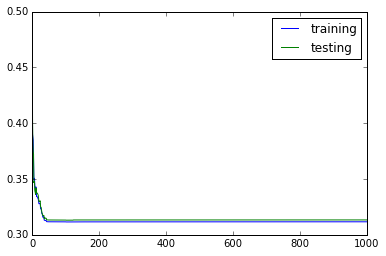

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.plot(f(accuracy_train[:]), label="training")
plt.plot(f(accuracy_test[:]), label="testing")
plt.legend()

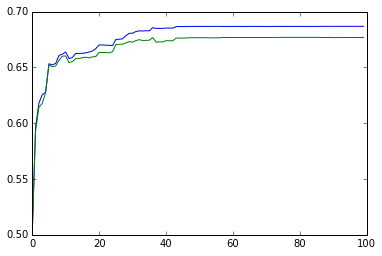

In [41]:
plt.plot(auc_train[:100])
plt.plot(auc_test[:100])

In [58]:
print "Test accuracy:", "%.2f" % (accuracy_test[-1] * 100) + '%'

Test accuracy: 68.67%


# Performance of LogitBoost

In [ ]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = test_improve(logitboost)

In [ ]:
# (accuracy_train, auc_train), (accuracy_test, auc_test) = pickle.load(open("result/logitboost_trend.pkl"))

In [ ]:
import pickle
pickle.dump(((accuracy_train, auc_train), (accuracy_test, auc_test)), open("result/logitboost_trend.pkl", 'w'))

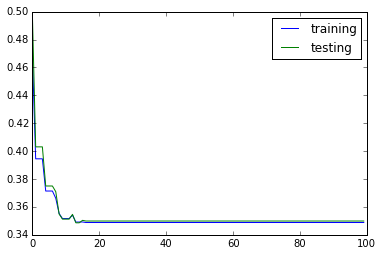

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.plot(f(accuracy_train[:100]), label="training")
plt.plot(f(accuracy_test[:100]), label="testing")
plt.legend()

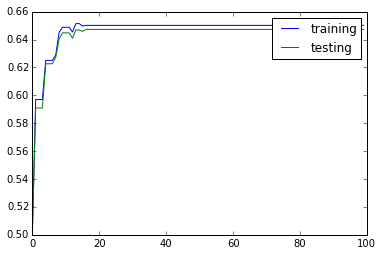

In [45]:
plt.plot(auc_train[:100], label="training")
plt.plot(auc_test[:100], label="testing")
plt.legend()

In [56]:
print "Test accuracy:", "%.2f" % (accuracy_test[-1] * 100) + '%'

Test accuracy: 65.01%
